In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as an

from learning.rl import RLModel, default_network_arch
import torch
import torch.nn.functional as F

perc_winners = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

# Display only specific experiments, model1 and vanilla
is_shortened = True

# Function to read latency data and compute CDF using pandas
def read_and_compute_latencies(filename):
    # Read data into a pandas Series
    data = pd.read_csv(filename, header=None, names=['latency'])
    # Sort the data
    data_sorted = data.sort_values(by='latency')
    # Compute CDF
    cdf = data_sorted.rank(method='average', pct=True)

    percentiles = [0.5, 0.9, 0.99]
    data_percentiles = data.quantile(percentiles)
    return data_sorted, cdf, data_percentiles

# Function to read vacuum actions
def read_vacuum_actions(filename):
    return pd.read_csv(filename, header=None, names=['time', 'vacuum_count', 'autovacuum_count', 'live_pct'], sep=" ")

def read_latencies_by_type(type):
    return read_and_compute_latencies("%s/tag_%s_%s_latencies.txt" % (base_dir, type, experiment_id))
    
# Load and compute CDFs
def read_latencies(experiment_id):
    result = [read_latencies_by_type(type) for type in ["model1", "model2", "pid", "vanilla"]]

    for perc_index in range(3):
        min_index = -1
        min_v = -1
        for index, e in enumerate(result):              
            e1 = e[2].values.flatten()[perc_index]
            if min_index == -1 or e1 < min_v:
                min_index = index
                min_v = e1

        perc_winners[perc_index][min_index] += 1
    
    return result

def plot_cdf(experiment_id, data):
    plt.figure(figsize=(8, 6))

    if is_shortened:
        plt.plot(data[0][0], data[0][1], label='CrystalDB AutoDBA')
        plt.plot(data[3][0], data[3][1], label='Postgres AutoVacuum')
    else:    
        plt.plot(data[0][0], data[0][1], label='CrystalDB AutoDBA (model1)')
        plt.plot(data[1][0], data[1][1], label='CrystalDB AutoDBA (model2)')
        plt.plot(data[2][0], data[2][1], label='CrystalDB AutoDBA (pid)')
        plt.plot(data[3][0], data[3][1], label='Postgres AutoVacuum')
    
    plt.xlabel('Latency (ms)')
    plt.ylabel('CDF')
    plt.title('CDF of Latencies (%s)' % experiment_id)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_percentiles(experiment_id, data):
    if is_shortened:
        combined_percentiles = pd.DataFrame({
            'CrystalDB AutoDBA': data[0][2].values.flatten(),
            'PostgreSQL Autovacuum': data[3][2].values.flatten()
        }, index=['50%', '90%', '99%'])
    else:    
        combined_percentiles = pd.DataFrame({
            'CrystalDB AutoDBA (model1)': data[0][2].values.flatten(),
            'CrystalDB AutoDBA (model2)': data[1][2].values.flatten(),
            'CrystalDB AutoDBA (pid)': data[2][2].values.flatten(),
            'PostgreSQL Autovacuum': data[3][2].values.flatten()
        }, index=['50%', '90%', '99%'])

    # Plotting
    combined_percentiles.plot(kind='bar', figsize=(10, 7))
    
    plt.title('Latencies by Percentile and PID Status (%s)' % experiment_id)
    plt.xlabel('Percentile')
    plt.ylabel('Latency')
    plt.xticks(rotation=0)  # Keep the percentile labels horizontal for readability
    plt.legend()
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

def plot_queries_completed(experiment_id, data):
    if is_shortened:
        combined_percentiles = pd.DataFrame({
            'CrystalDB AutoDBA': [len(data[0][0].values.flatten())],
            'PostgreSQL Autovacuum': [len(data[3][0].values.flatten())]
        }, index=['Queries completed'])
    else:
        combined_percentiles = pd.DataFrame({
            'CrystalDB AutoDBA (model1)': [len(data[0][0].values.flatten())],
            'CrystalDB AutoDBA (model2)': [len(data[1][0].values.flatten())],
            'CrystalDB AutoDBA (pid)': [len(data[2][0].values.flatten())],
            'PostgreSQL Autovacuum': [len(data[3][0].values.flatten())]
        }, index=['Queries completed'])

    # Plotting
    combined_percentiles.plot(kind='bar', figsize=(10, 7))
    
    plt.title('Queries completed (%s)' % experiment_id)
    #plt.xlabel('Number of queries')
    plt.ylabel('Number of queries')
    plt.xticks(rotation=0)  # Keep the percentile labels horizontal for readability
    plt.legend()
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

def plot_actions(prefix, experiment_id, data):  
    plt.figure(figsize=(8, 6))
    plt.plot(data['time'].to_list(), [100*t for t in data['live_pct'].to_list()], label='Live tuple percent')
    plt.plot(data['time'].to_list(), [max(l1, l2) for l1, l2 in zip(data['vacuum_count'].to_list(), data['autovacuum_count'].to_list())], label='Vacuum count')
   
    plt.xlabel('Time (s)')
    plt.title('Actions (%s, %s)' % (prefix, experiment_id))
    plt.legend()
    plt.grid(True)
    plt.show()

def animated_actions_plot(prefix, experiment_id):
    #print("Input model name:")
    #model_filename = input()
    model_filename = "/home/svilen-mihaylov/temp/rl/models/real4/real4.pth"
    model = RLModel(default_network_arch)
    model.load_state_dict(torch.load(model_filename)['model_state_dict'])

    
    tag = "tag_%s_%s" % (prefix, experiment_id)
    data = read_vacuum_actions("%s/%s_actions.txt" % (base_dir, tag))
    
    with open("%s/graph/%s_states.txt" % (base_dir, tag), 'r') as fs:
        lines = fs.readlines()

    plt.rcParams["animation.html"] = "jshtml"
    #plt.rcParams['figure.dpi'] = 150  
    plt.rcParams["animation.embed_limit"] = 100*1024*1024 #100 MB

    fig, ax = plt.subplots(figsize=(12, 6))

    def softmax(x, factor):
        e_x = np.exp(factor*(x - np.max(x)))
        return e_x / e_x.sum()

    prev_states = {}
    def plot_state(id, vals, ext, factor):                 
        match id:
            case 2:
                # For hidden layer, for visibility display the "delta" instead of the current values
                v = vals
                if id in prev_states:
                    p = prev_states[id]
                    vals = [vals[i]-p[i] for i in range(len(vals))]
                prev_states[id] = v
            case 3:
                # Draw gauge
                plt.plot([28, 32], [85, 85], color='black')

                sm = softmax(vals, factor)
                ratio = sm[1]/(sm[0]+sm[1])
                
                plt.plot([28+4*ratio, 28.2+4*ratio], [86.5, 86], color='black')                
                plt.plot([28+4*ratio, 27.8+4*ratio], [86.5, 86], color='black')       
        
        #plt.text(ext[0], ext[3], str([round(v, 1) for v in vals]))
            
        d1 = np.expand_dims(np.array(softmax(vals, factor)), axis=0)
        plt.imshow(d1, interpolation='nearest', extent=ext, aspect='auto', vmax=abs(d1).max(), vmin=-abs(d1).max())
        
    def animate(t):
        plt.cla()      
        
        # Look at first 60s
        plt.xlim(0, 60)
        plt.ylim(0, 120)
        
        plt.plot(data['time'].to_list()[:t], [100*t for t in data['live_pct'].to_list()][:t], label='Live tuple percent')        
        plt.plot(data['time'].to_list()[:t], data['vacuum_count'].to_list()[:t], label='Vacuum count')
        
        plt.xlabel('Time (s)')
        plt.title('Actions (%s, %s)' % (prefix, experiment_id))
        plt.legend()
        plt.grid(True)


        line = lines[t]
        input_vals = [float(v) for v in line.split(',')]    
        hidden_values_t = model.fc1(torch.tensor(input_vals))
        output_values_t = model.fc2(F.relu(hidden_values_t))

        hidden_values = hidden_values_t.tolist()
        output_values = output_values_t.tolist()

        plt.text(18, 112, "Input layer")
        plot_state(0, input_vals[:10], [25, 30, 108, 112], 10)
        plot_state(1, input_vals[10:], [30, 35, 108, 112], 1)

        plt.text(18, 102, "Hidden layer")    
        plot_state(2, hidden_values, [5, 55, 98, 102], 1)

        plt.text(18, 92, "Output layer")    
        plt.text(26, 88, "Idle")    
        plt.text(32, 88, "Vacuum")    
        plot_state(3, output_values, [28, 32, 88, 92], 0.1)

    # Plot only first 40s.
    anim = an.FuncAnimation(fig, animate, frames=40)
    return anim
    
def plot_graphs(experiment_id):
    latency_data = read_latencies(experiment_id)
    plot_cdf(experiment_id, latency_data)
    plot_percentiles(experiment_id, latency_data)
    plot_queries_completed(experiment_id, latency_data)

    for prefix in ['model1', 'model2', 'pid', 'vanilla']:
        actions_data = read_vacuum_actions("%s/tag_%s_%s_actions.txt" % (base_dir, prefix, experiment_id))
        plot_actions(prefix, experiment_id, actions_data)

Input directory with results:


 /home/svilen-mihaylov/temp/rl/results/r14


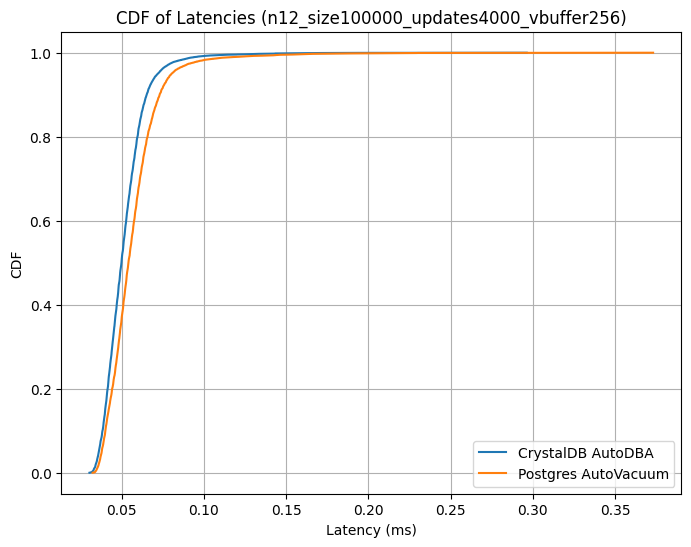

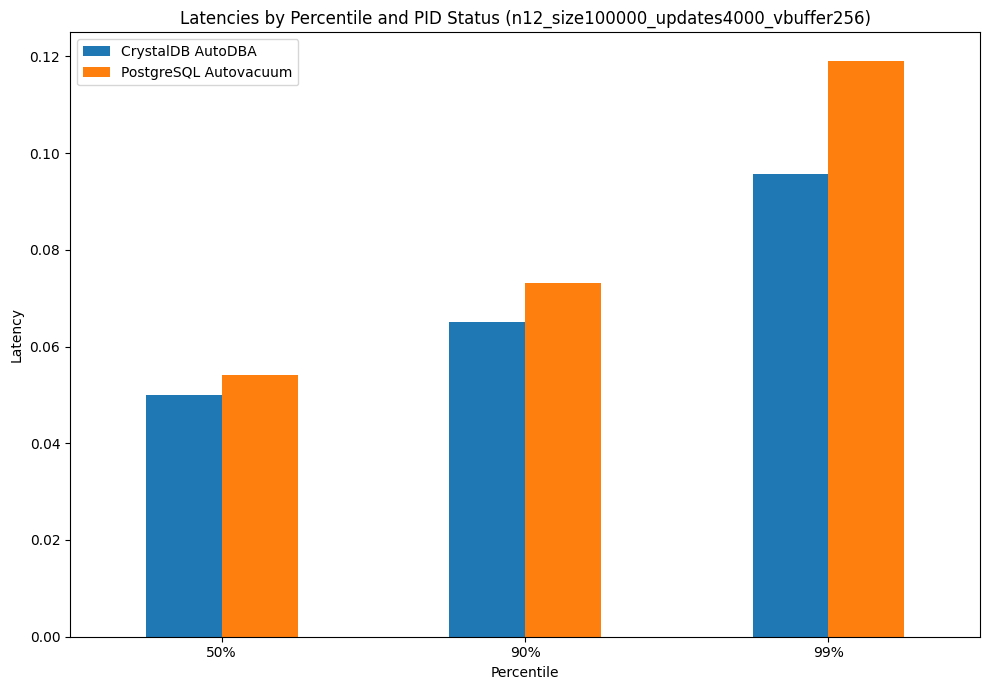

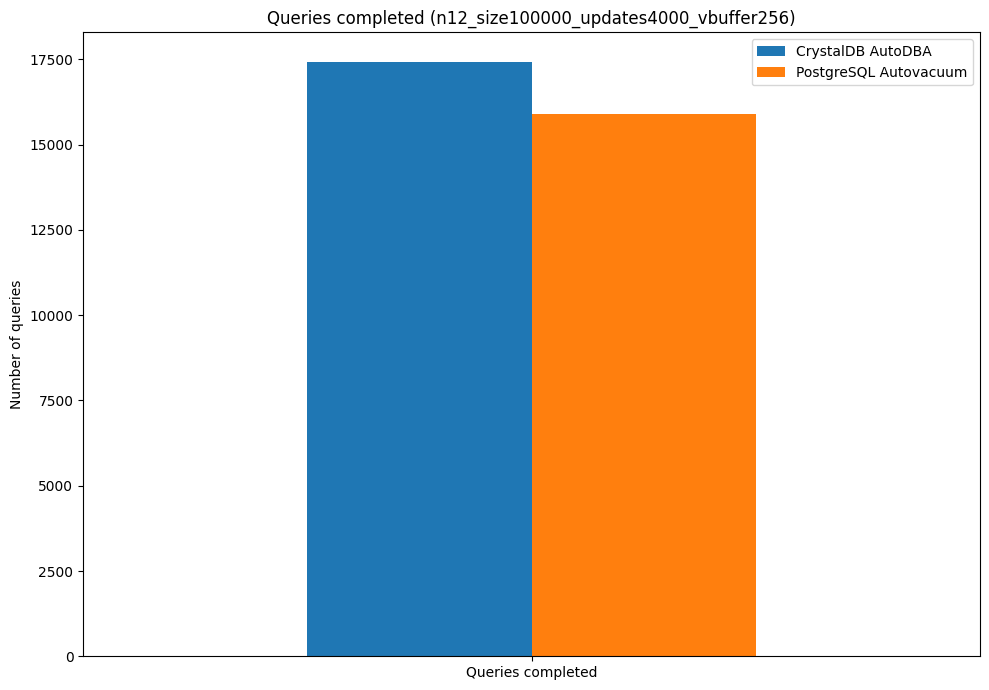

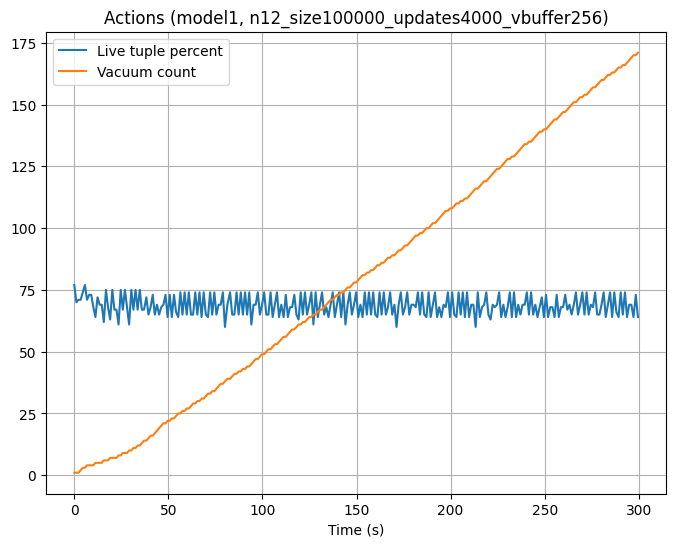

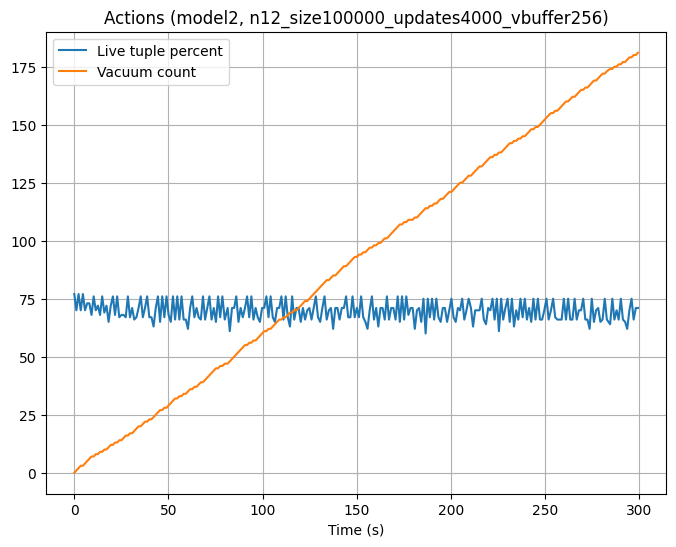

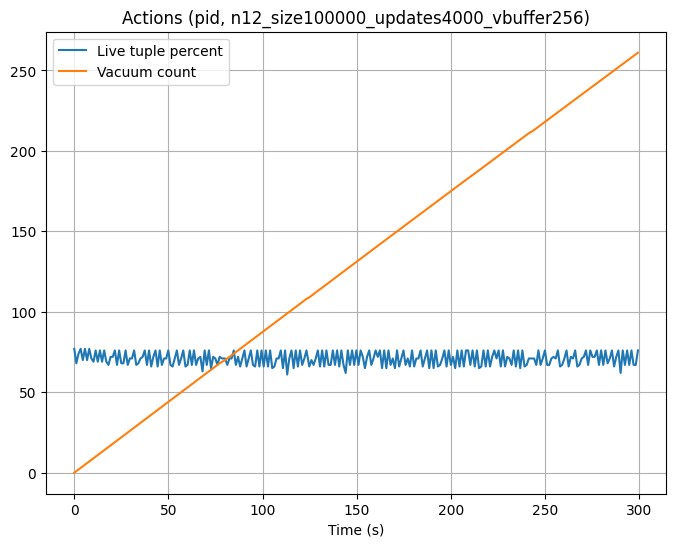

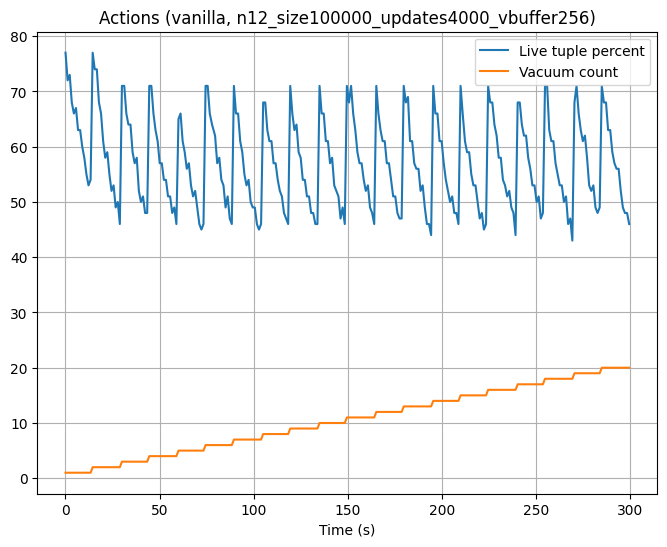

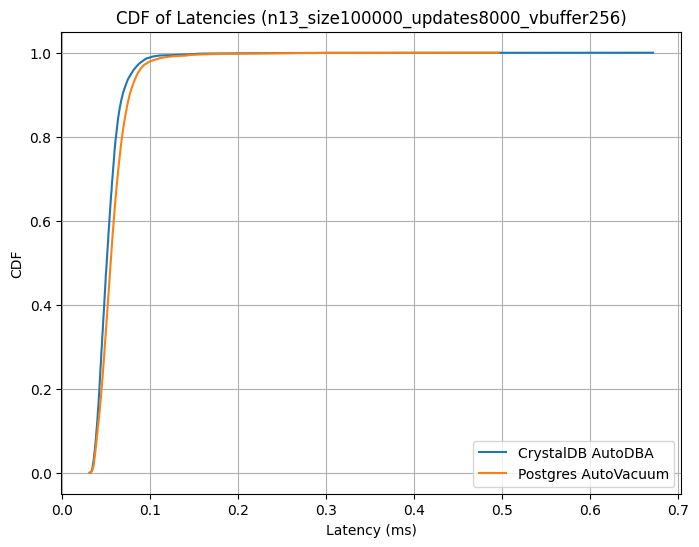

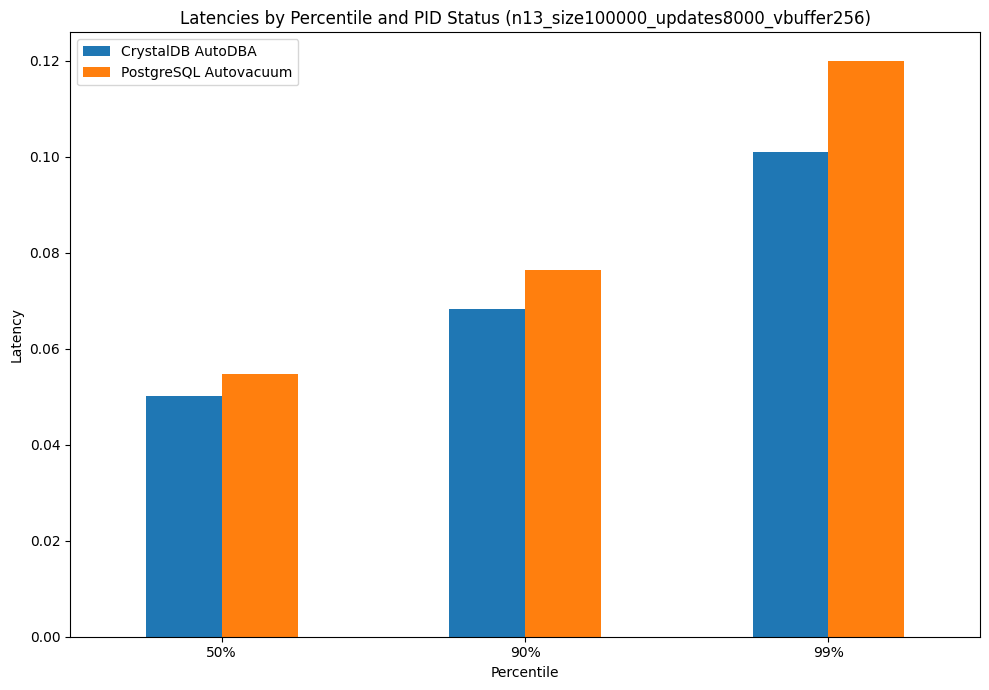

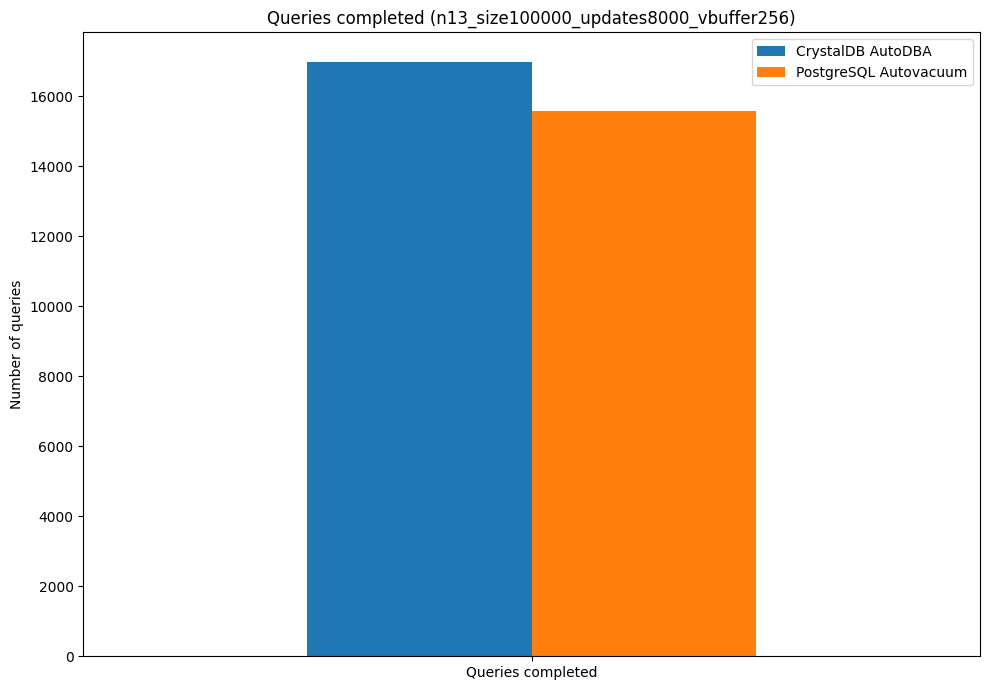

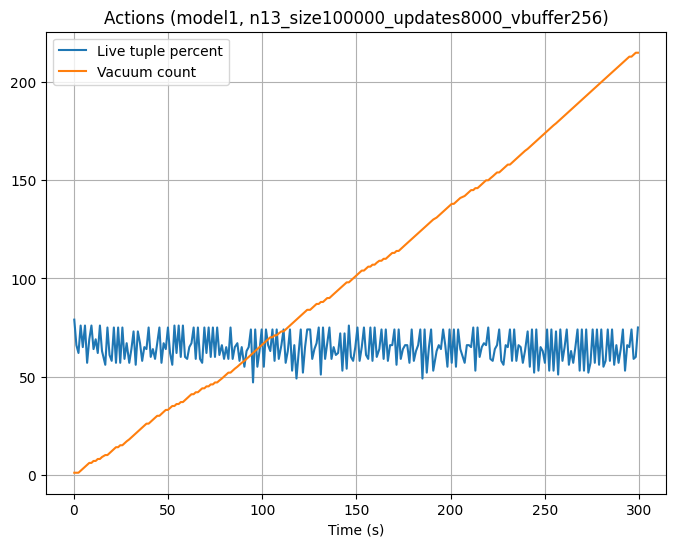

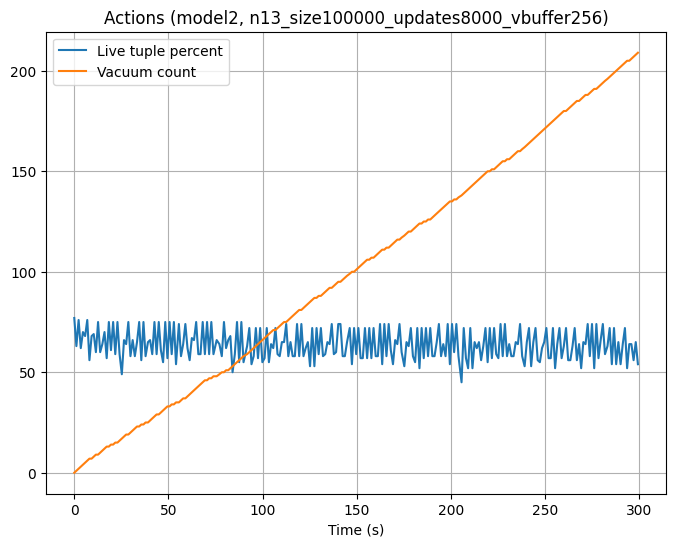

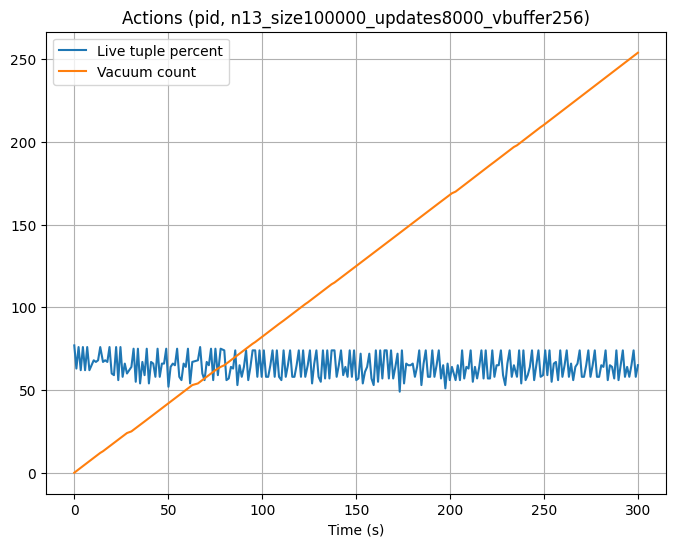

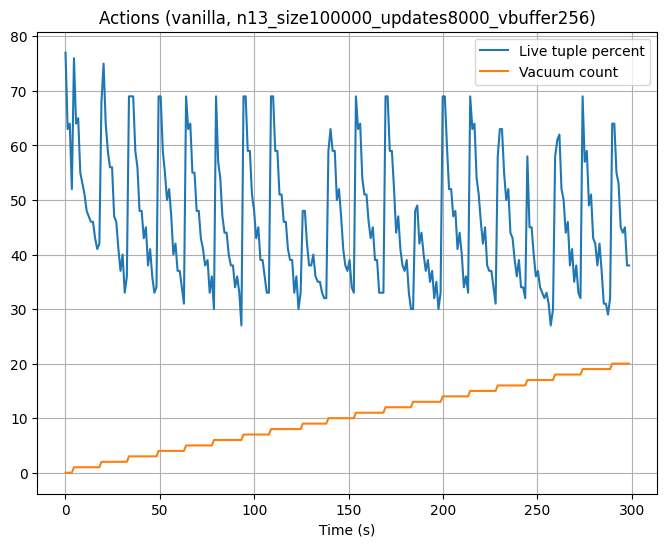

Generating animation...


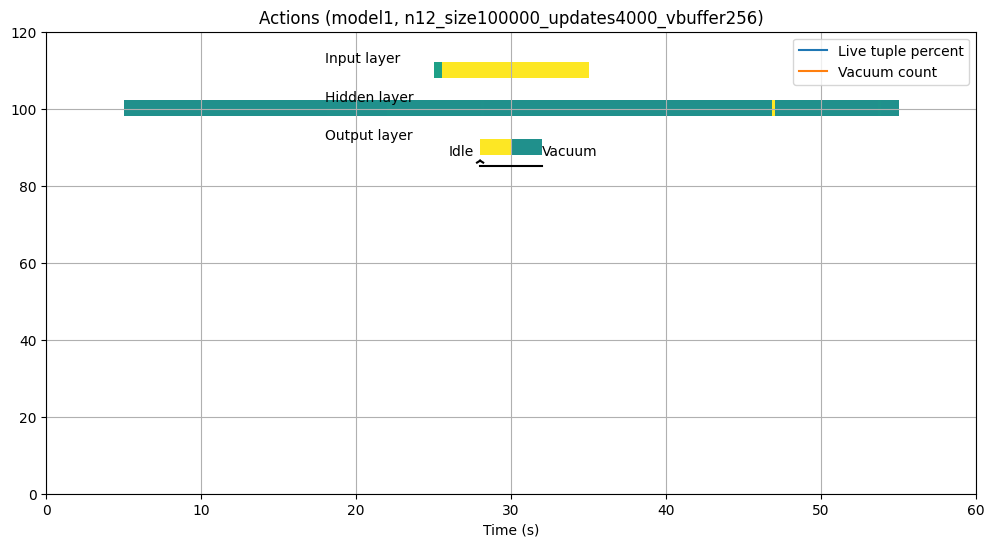

In [2]:
global base_dir
print("Input directory with results:")
base_dir = input()

id = 0
exp_ids = []
for initial_size in [10000, 100000, 1000000, 10000000]:
    for update_speed in [500, 1000, 2000, 4000, 8000, 16000, 32000, 64000]:
        id += 1
        experiment_id = "n%d_size%d_updates%d_vbuffer256" % (id, initial_size, update_speed)
        exp_ids.append(experiment_id)
        
        if (not is_shortened or id == 12 or id == 13) and initial_size == 100000 and update_speed >= 1000 and update_speed <= 32000:
            plot_graphs(experiment_id)   

#print("Percentile winners: ", perc_winners)

print("Generating animation...")
r = animated_actions_plot("model1", exp_ids[11])
# Need to specifically do this below:
r